### Interaction of seagoing and dredging with multi-container

This notebook is developed to visualize the interaction between seagoing and dredging operations in which:

* Dredging and seagoing vessels are identical separately.
* The number of dredging and seagoing vessels, amount of soil/cargo, and berth capacity can be controlled.

The following steps are proposed to setup the simulation.

#### 0. Import libraries

In [1]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium

#### 1. Define object classes

In [2]:
# create a Site object based on desired mixin classes
Site = type('Site',
            (core.Identifiable,
             core.Log,
             core.Locatable,
             core.HasMultiContainer,
             core.HasResource,), {})

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.MultiContainerDependentMovable,
        core.HasResource,
        core.HasContainer,
        core.Processor,
        core.Identifiable,
        core.Log,
        # core.LoadingFunction,
        # core.UnloadingFunction,
        # capture extra metadata to make sure we don't have leftover arguments
        opentnsim.core.ExtraMetadata
    ),
    {},
)

#### 2. Define run, site objects, and vessel objects

In [3]:
def run(nr_seagoing_vessels, nr_dredging_vessels, total_container, total_soil):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}


    # create site objects
    # prepare data for offshore locations
    location_offshore = shapely.geometry.Point(3.637610458072877, 52.10701582514347)
    data_offshore = {"env": my_env,
                    "name": "offshore",
                    "geometry": location_offshore,
                    "initials": [
                        {"id": "Container", "level": 0, "capacity": 0},
                        {"id": "Soil", "level": 0, "capacity": 0},
                        ],
                    "nr_resources": nr_seagoing_vessels,
                    }
    offshore = Site(**data_offshore)


    # prepare input data for berth
    location_berth = shapely.geometry.Point(4.062705498083785,51.95909715255291)
    data_berth = {"env": my_env,
                "name": "berth",
                "geometry": location_berth,
                    "initials": [
                        {"id": "Container", "level": 10, "capacity": total_container},
                        {"id": "Soil", "level": 20, "capacity": total_soil},
                        ],
                "nr_resources": 1
                }
    berth = Site(**data_berth)


    # prepare input data for dump
    location_dump = shapely.geometry.Point(4.1795229742823,52.11590591837503)
    data_dump = {"env": my_env,
                "name": "dump",
                "geometry": location_dump,
                    "initials": [
                        {"id": "Container", "level": 0, "capacity": 0},
                        {"id": "Soil", "level": 0, "capacity": total_soil},
                        ],
                }
    dump = Site(**data_dump)


    # create vessel objects
    vessels = {}

    for i in range(nr_dredging_vessels):
        vessels[f"dredging_vessel{i}"] = TransportProcessingResource (
            env = my_env,
            name = f"dredging_vessel{i}",
            geometry = location_dump,
            initials = [
                {"id": "Container", "level": 0, "capacity": 0},
                {"id": "Soil", "level": 0, "capacity": 6},
                ],
            loading_rate = 1,
            undloading_rate = 2,
            compute_v = lambda x: 10 + 2 * x,
                )
    dredging_vessel = TransportProcessingResource(
        env = my_env,
            name = f"dredging_vessel{i}",
            geometry = location_dump,
            initials = [
                {"id": "Container", "level": 0, "capacity": 0},
                {"id": "Soil", "level": 0, "capacity": 6},
                ],
            loading_rate = 1,
            undloading_rate = 2,
            compute_v = lambda x: 10 + 2 * x,
                )
    
    for i in range (nr_dredging_vessels):
        vessels['dredging_vessel'] = dredging_vessel


    for i in range (nr_seagoing_vessels):
        vessels[f"seagoing_vessel{i}"] = TransportProcessingResource (
            env = my_env,
            name = f"seagoing_vessel{i}",
            geometry = location_offshore,
            initials = [
                {"id": "Container", "level": 15, "capacity": 15},
                {"id": "Soil", "level": 0, "capacity": 0},
                ],
            loading_rate = 2,
            undloading_rate = 2,
            compute_v = lambda x: 10 + 2 * x,
                )
    seagoing_vessel = TransportProcessingResource(
        env = my_env,
            name = f"seagoing_vessel{i}",
            geometry = location_offshore,
            initials = [
                {"id": "Container", "level": 15, "capacity": 15},
                {"id": "Soil", "level": 0, "capacity": 0},
                ],
            loading_rate = 2,
            undloading_rate = 2,
            compute_v = lambda x: 10 + 2 * x,
                )
    for i in range (nr_seagoing_vessels):
        vessels['seagoing_vessel'] = seagoing_vessel



    #Create activity objects
    activities_dredging_vessel = {}
    activities_seagoing_vessel = {}

    for i in range (nr_dredging_vessels):
        requested_resources = {}
        
        dredging_subprocesses = [
                model.MoveActivity(
                            env=my_env,
                            name=f"sailing_empty:"+vessels[f"dredging_vessel{i}"].name,
                            registry=registry,
                            mover=vessels[f"dredging_vessel{i}"],
                            destination=berth,
                            duration=20,
                    ),
                model.ShiftAmountActivity(
                            env=my_env,
                            name=f"loading:"+vessels[f"dredging_vessel{i}"].name,
                            registry=registry,
                            processor=vessels[f"dredging_vessel{i}"],
                            origin=berth,
                            destination=vessels[f"dredging_vessel{i}"],
                            amount=4,
                            duration=50,
                            id_="Soil",
                            requested_resources=requested_resources,
                    ),
                model.MoveActivity(
                            env=my_env,
                            name=f"sailing_full:"+vessels[f"dredging_vessel{i}"].name,
                            registry=registry,
                            mover=vessels[f"dredging_vessel{i}"],
                            destination=dump,
                            duration=15,
                    ),
                model.ShiftAmountActivity(
                            env=my_env,
                            name=f"unloading:"+vessels[f"dredging_vessel{i}"].name,
                            registry=registry,
                            processor=vessels[f"dredging_vessel{i}"],
                            origin=vessels[f"dredging_vessel{i}"],
                            destination=dump,
                            amount=4,
                            duration=25,
                            id_="Soil",
                            requested_resources=requested_resources,
                    )
            ]
        
        activities_dredging_vessel[f"activities_dredging_vessel{i}"] = model.WhileActivity(
            env = my_env,
            name = f"while_sequential_activity_dredging_vessel{i}",
            registry = registry,
            sub_processes= [model.SequentialActivity(
                env = my_env,
                name = f"sequential_activity_dredging_vessel{i}",
                registry = registry,
                sub_processes = dredging_subprocesses
            )],
            condition_event = [{"type": "container",
                                "concept": berth,
                                "state": "empty",
                                "id_": "default_reservations"}
                                ]
        )
    
    
    for i in range (nr_seagoing_vessels):
        requested_resources = {}
        
        seagoing_subprocesses = [
                model.MoveActivity(
                            env=my_env,
                            name=f"sailing_full:"+vessels[f"seagoing_vessel{i}"].name,
                            registry=registry,
                            mover=vessels[f"seagoing_vessel{i}"],
                            destination=berth,
                            duration=10,
                    ),
                model.ShiftAmountActivity(
                            env=my_env,
                            name=f"unloading:"+vessels[f"seagoing_vessel{i}"].name,
                            registry=registry,
                            processor=vessels[f"seagoing_vessel{i}"],
                            origin=vessels[f"seagoing_vessel{i}"],
                            destination=berth,
                            amount=5,
                            duration=30,
                            id_="Container",
                            requested_resources=requested_resources,
                    ),
                model.MoveActivity(
                            env=my_env,
                            name=f"sailing_empty:"+vessels[f"seagoing_vessel{i}"].name,
                            registry=registry,
                            mover=vessels[f"seagoing_vessel{i}"],
                            destination=offshore,
                            duration=5,
                    ),
            ]
        
        activities_seagoing_vessel[f"activities_seagoing_vessel{i}"] = model.WhileActivity(
            env = my_env,
            name = f"while_sequential_activity_seagoing_vessel{i}",
            registry = registry,
            sub_processes= [model.SequentialActivity(
                env = my_env,
                name = f"sequential_activity_seagoing_vessel{i}",
                registry = registry,
                sub_processes = seagoing_subprocesses
            )],
            condition_event = [{"type": "container",
                                "concept": vessels[f"seagoing_vessel{i}"],
                                "state": "empty",
                                "id_": "default_reservations"}
                                ]
        )
    

    model.register_processes([*activities_dredging_vessel.values(), *activities_seagoing_vessel.values()])
    my_env.run()

    return {
        "vessels": vessels,
        "activities_dredging_vessel": activities_dredging_vessel,
        "activities_seagoing_vessel": activities_seagoing_vessel,
        "offshore": offshore,
        "berth": berth,
        "dump": dump,
    }


#### 3. Control simulation attributes and run

In [4]:
%%time

res = run(3,3,50,30)
vessels = res['vessels']
activities_dredging_vessel = res['activities_dredging_vessel']
activities_seagoing_vessel = res['activities_seagoing_vessel']
dredging_vessel = vessels['dredging_vessel']
seagoing_vessel = vessels['seagoing_vessel']
offshore = res['offshore']
berth = res['berth']
dump = res['dump']

mover dredging_vessel0 destination berth
mover dredging_vessel1 destination berth
mover dredging_vessel2 destination berth
mover seagoing_vessel0 destination berth
mover seagoing_vessel1 destination berth
mover seagoing_vessel2 destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover seagoing_vessel0 destination offshore
updating to destination geometry POINT (3.637610458072877 52.10701582514347)
mover seagoing_vessel1 destination offshore
updating to destination geometry POINT (3.637610458072877 52.10701582514347)
mover seagoing_vessel2 destination offshore
updati

#### 4. Inspect results

##### 4.1. Visualize gantt chart

In [5]:
fig = plot.get_gantt_chart([*vessels.values()], id_map=[*activities_dredging_vessel.values(), *activities_seagoing_vessel.values()])

In [6]:
fig = plot.get_gantt_chart(
    [berth, dump, dredging_vessel],
    id_map=[*activities_dredging_vessel.values()]
)

In [7]:
fig = plot.get_gantt_chart(
    [berth, seagoing_vessel],
    id_map=[*activities_seagoing_vessel.values()]
)

In [8]:
def expand(a, namespace):
    n = len(namespace)
    sa = []
    if a.name[0:n]==namespace:
        sa.append(a)
    if hasattr(a, "sub_processes"):
        for s in a.sub_processes:
            if s.name[0:n]==namespace:
                sa.append(s)
            sa+=expand(s,namespace)
    return sa
all_activities_hopper = []
for a in [*activities_dredging_vessel]:
    all_activities_hopper+=expand(activities_dredging_vessel[a],'load')
all_activities_hopper
fig = plot.get_gantt_chart(all_activities_hopper)

In [9]:
# plot only loading activities of dredging vessels

def expand(a, namespace):
    n = len(namespace)
    sa = []
    if a.name[0:n]==namespace:
        sa.append(a)
    if hasattr(a, "sub_processes"):
        for s in a.sub_processes:
            if s.name[0:n]==namespace:
                sa.append(s)
            sa+=expand(s,namespace)
    return sa
all_activities = []
for a in [*activities_dredging_vessel]:
    all_activities+=expand(activities_dredging_vessel[a],'load')
all_activities
fig = plot.get_gantt_chart(all_activities)

##### 4.2. Visualise container and soil volume developments

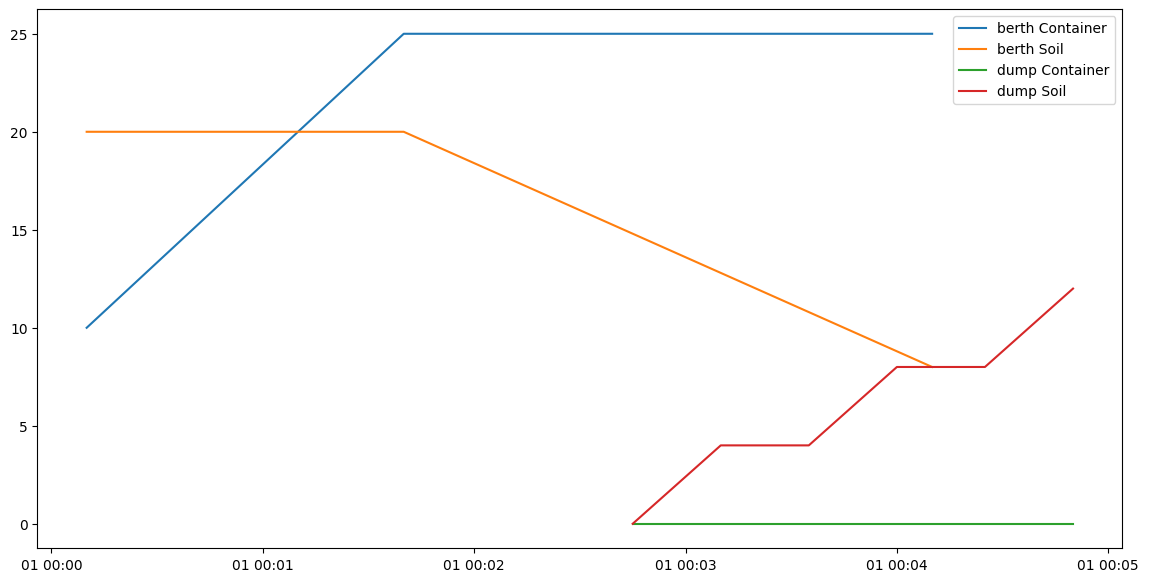

In [10]:
fig = plot.get_step_chart([berth, dump])